**Green Taxi**

Install Required Libraries

Imports and Environment Setup

In [ ]:
!pip install apache-beam[gcp] matplotlib pandas google-cloud-storage google-cloud-bigquery --quiet
!pip install dask==2024.10.0 cloudpickle==3.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.5/173.5 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.6/432.6 kB 23.1 MB/s 

In [ ]:
import os
from google.cloud import storage
from google.cloud import bigquery
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
import matplotlib.pyplot as plt
import pandas as pd

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/savvy-bay-412910-f10d0263e13e.json'


GCS Bucket Utilities

In [ ]:
# Utility to create a bucket
def create_bucket(bucket_name, storage_class='STANDARD', location='us-central1'):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    bucket.storage_class = storage_class
    bucket = client.create_bucket(bucket, location=location)
    print(f"Bucket {bucket_name} created successfully!")
    return bucket.name

# Check if bucket exists or create a new one
def check_or_create_bucket(client, bucket_name):
    try:
        client.get_bucket(bucket_name)
        print(f'Bucket "{bucket_name}" exists!')
    except Exception:
        create_bucket(bucket_name)


Data Extraction Utility

In [ ]:
import requests

# Function to fetch data from URL
def fetch_data(url):
    params = {'$limit': 39656098, '$$app_token': "akmhOJDahBDbT6dtEV8WJETnr"}
    response = requests.get(url, params=params)
    response_data = response.json()
    df = pd.json_normalize(response_data)
    print("Data fetched successfully!")
    return df


Upload Data to GCS

In [ ]:
# Function to upload data to GCS
def upload_to_gcs(client, bucket_name, data, filename):
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(filename)
    blob.upload_from_string(data.to_csv(), "text/csv")
    print(f"{filename} uploaded to {bucket_name} successfully!")


Define Dataflow Pipeline

In [ ]:
# Function to run Apache Beam Dataflow Pipeline
def run_dataflow_pipeline(input_bucket, table_name, dataset_name, project_id):
    pipeline_options = {
        'project': project_id,
        'runner': 'DataflowRunner',
        'region': 'us-west1',
        'staging_location': f'gs://{input_bucket}/temp',
        'temp_location': f'gs://{input_bucket}/temp',
    }
    pipeline_options = PipelineOptions.from_dictionary(pipeline_options)
    pipeline = beam.Pipeline(options=pipeline_options)

    def filter_missing_value(element):
        return all(element)

    def split_date(element):
        element.append((element[2].split('T'))[0])
        element.append(((element[2].split('T')[1]).split('.'))[0])
        element.append((element[3].split('T'))[0])
        element.append(((element[3].split('T')[1]).split('.'))[0])
        return element

    def format_for_bq(element):
        return {
            'vendorid': int(element[1]),
            'store_and_fwd_flag': element[4],
            'ratecodeid': int(float(element[5])),
            'pulocationid': float(element[6]),
            'dolocationid': float(element[7]),
            'passenger_count': int(float(element[8])),
            'trip_distance': float(element[9]),
            'fare_amount': float(element[10]),
            'extra': float(element[11]),
            'mta_tax': float(element[12]),
            'tip_amount': float(element[13]),
            'tolls_amount': float(element[14]),
            'improvement_surcharge': float(element[15]),
            'total_amount': float(element[16]),
            'payment_type': element[17],
            'trip_type': element[18],
            'congestion_surcharge': float(element[19]),
            'pickup_date': element[20],
            'pickup_time': element[21],
            'dropoff_date': element[22],
            'dropoff_time': element[23],
        }

    (
        pipeline
        | "Read CSVs" >> beam.io.ReadFromText(f'gs://{input_bucket}/*.csv', skip_header_lines=1)
        | "Split Rows" >> beam.Map(lambda row: row.split(','))
        | "Filter Missing Values" >> beam.Filter(filter_missing_value)
        | "Split Date Columns" >> beam.Map(split_date)
        | "Format for BigQuery" >> beam.Map(format_for_bq)
        | "Write to BigQuery" >> beam.io.WriteToBigQuery(
            table=table_name,
            dataset=dataset_name,
            project=project_id,
            schema='vendorid:INT64,store_and_fwd_flag:STRING,ratecodeid:INT64,pulocationid:FLOAT64,'
                   'dolocationid:FLOAT64,passenger_count:INT64,trip_distance:FLOAT64,fare_amount:FLOAT64,'
                   'extra:FLOAT64,mta_tax:FLOAT64,tip_amount:FLOAT64,tolls_amount:FLOAT64,'
                   'improvement_surcharge:FLOAT64,total_amount:FLOAT64,payment_type:STRING,trip_type:STRING,'
                   'congestion_surcharge:FLOAT64,pickup_date:STRING,pickup_time:STRING,dropoff_date:STRING,'
                   'dropoff_time:STRING',
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
        )
    )
    pipeline.run().wait_until_finish()
    print("Dataflow pipeline executed successfully!")


Visualising Data from BigQuery

In [ ]:
# Function to visualize BigQuery data
def visualize_data(client, dataset_id, table_id):
    sns.set_theme(style="whitegrid")

    # Query for daily earnings
    daily_earnings_query = f"""
    SELECT pickup_date, SUM(total_amount) AS daily_earnings
    FROM `{client.project}.{dataset_id}.{table_id}`
    GROUP BY pickup_date
    ORDER BY pickup_date
    """
    daily_earnings = client.query(daily_earnings_query).to_dataframe()
    # Convert pickup_date to datetime
    daily_earnings['pickup_date'] = pd.to_datetime(daily_earnings['pickup_date'], errors='coerce')
    # Filter data for 2022 only
    daily_earnings = daily_earnings[(daily_earnings['pickup_date'] >= '2022-01-01') &
                                    (daily_earnings['pickup_date'] <= '2022-12-31')]

    # Drop rows with invalid dates
    daily_earnings = daily_earnings.dropna(subset=['pickup_date'])
    # Plot Daily Earnings (Line only)
    plt.figure(figsize=(12, 7))
    sns.lineplot(x='pickup_date', y='daily_earnings', data=daily_earnings, linewidth=2, color="teal")

    # Highlight highest point (Optional)
    highest_point = daily_earnings[daily_earnings['daily_earnings'] == daily_earnings['daily_earnings'].max()]
    plt.scatter(highest_point['pickup_date'], highest_point['daily_earnings'], color='red', label=f"Highest: {highest_point['daily_earnings'].values[0]:.2f}")

    # Format X-axis to show month names
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Display Month Year
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Major ticks at monthly intervals
    plt.title('Daily Earnings for Green Taxi Trips (2022)', fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Total Earnings $', fontsize=12)
    plt.xticks(rotation=45)  # Rotate for better readability
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Query for high-demand pickup locations
    high_demand_locations_query = f"""
    SELECT pulocationid, COUNT(*) AS pickup_count
    FROM `{client.project}.{dataset_id}.{table_id}`
    GROUP BY pulocationid
    ORDER BY pickup_count DESC
    LIMIT 10
    """
    pickup_locations_result = client.query(high_demand_locations_query).to_dataframe()

    # Visualize High-Demand Pickup Locations
    plt.figure(figsize=(12, 7))
    sns.barplot(x=pickup_locations_result['pulocationid'].astype(str), y=pickup_locations_result['pickup_count'], palette="viridis")
    highest_pickup = pickup_locations_result[pickup_locations_result['pickup_count'] == pickup_locations_result['pickup_count'].max()]
    plt.text(highest_pickup.index[0], highest_pickup['pickup_count'].values[0] + 5, f"{highest_pickup['pickup_count'].values[0]}", ha='center', color='red', weight='bold')
    plt.title('Top 10 High-Demand Pickup Locations', fontsize=16, weight='bold')
    plt.xlabel('Pickup Location ID', fontsize=12)
    plt.ylabel('Number of Pickups', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Execute the Pipeline

In [ ]:
# Initialize Clients
storage_client = storage.Client()
bq_client = bigquery.Client()

# Define Parameters
bucket_name = "greentaxitrip2022_72"
data_url = "https://data.cityofnewyork.us/resource/8nfn-ifaj.json"
file_name = "Green_Taxi_2022.csv"
project_id = "savvy-bay-412910"
dataset_name = "dataflow_demo"
table_name = "batch_data"

# Check or create bucket
check_or_create_bucket(storage_client, bucket_name)

# Fetch data and upload to GCS
data = fetch_data(data_url)
upload_to_gcs(storage_client, bucket_name, data, file_name)

# Run Dataflow pipeline
run_dataflow_pipeline(bucket_name, table_name, dataset_name, project_id)

# Visualize results
visualize_data(bq_client, dataset_name, table_name)


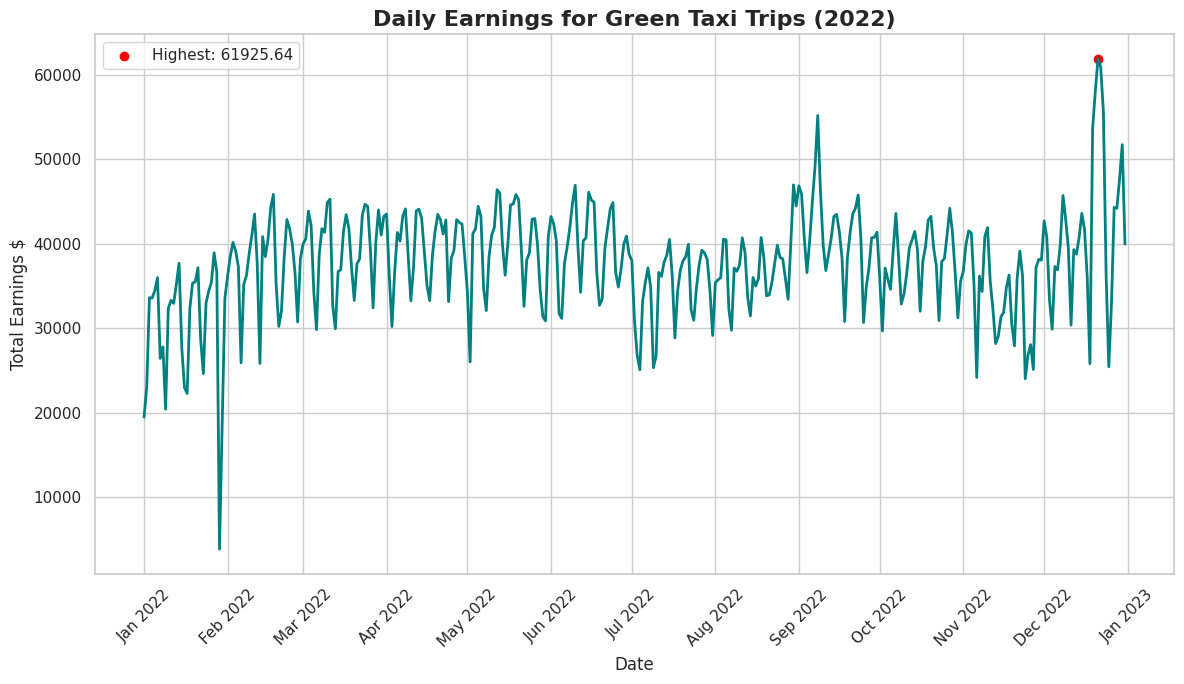

<ipython-input-19-cdac4fb6e064>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pickup_locations_result['pulocationid'].astype(str), y=pickup_locations_result['pickup_count'], palette="viridis")


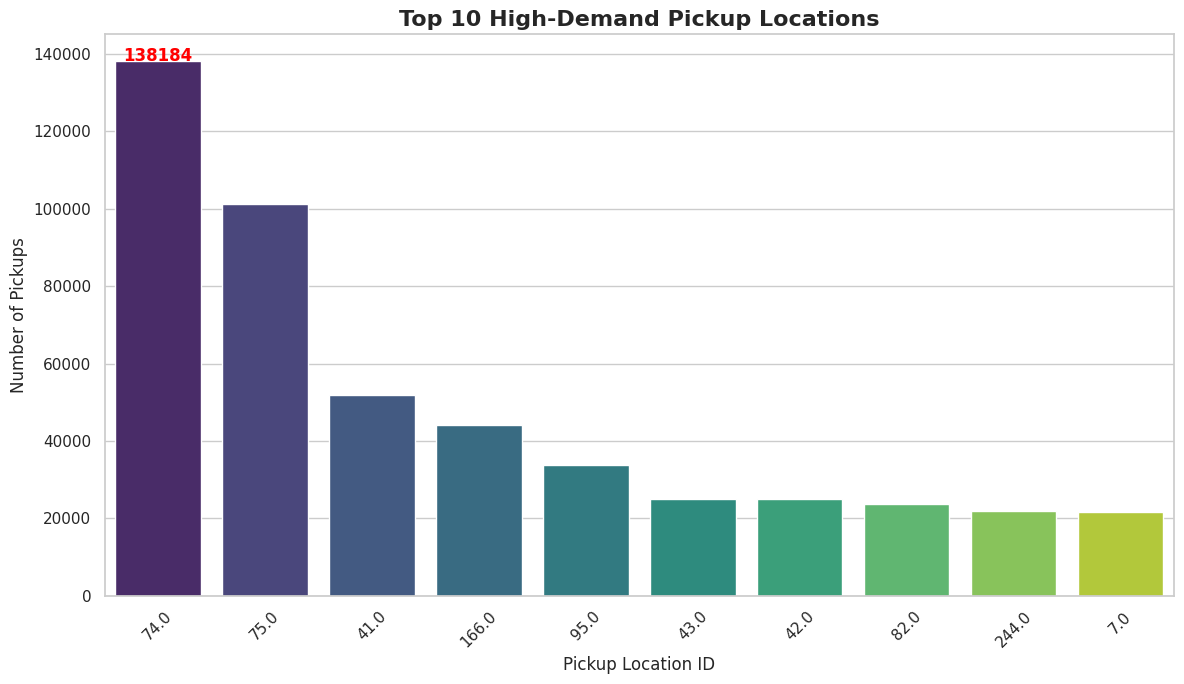

In [ ]:
# Visualize results
visualize_data(bq_client, dataset_name, table_name)